In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

import numpy as np

import copy

import argparse

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/Duong-Dat/Test_Pytorch/src'

/content/drive/Shareddrives/Duong-Dat/Test_Pytorch/src


In [4]:
pwd

'/content/drive/Shareddrives/Duong-Dat/Test_Pytorch/src'

### SAMPLING

In [5]:
def mnist_iid(dataset, num_users):
    """
    Sample I.I.D. client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [6]:
def mnist_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  200 imgs/shard X 300 shards
    num_shards, num_imgs = 200, 300
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [7]:
def mnist_noniid_unequal(dataset, num_users):
    """
    Sample non-I.I.D client data from MNIST dataset s.t clients
    have unequal amount of data
    :param dataset:
    :param num_users:
    :returns a dict of clients with each clients assigned certain
    number of training imgs
    """
    # 60,000 training imgs --> 50 imgs/shard X 1200 shards
    num_shards, num_imgs = 1200, 50
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = dataset.train_labels.numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # Minimum and maximum shards assigned per client:
    min_shard = 1
    max_shard = 30

    # Divide the shards into random chunks for every client
    # s.t the sum of these chunks = num_shards
    random_shard_size = np.random.randint(min_shard, max_shard+1,
                                          size=num_users)
    random_shard_size = np.around(random_shard_size /
                                  sum(random_shard_size) * num_shards)
    random_shard_size = random_shard_size.astype(int)

    # Assign the shards randomly to each client
    if sum(random_shard_size) > num_shards:

        for i in range(num_users):
            # First assign each client 1 shard to ensure every client has
            # atleast one shard of data
            rand_set = set(np.random.choice(idx_shard, 1, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        random_shard_size = random_shard_size-1

        # Next, randomly assign the remaining shards
        for i in range(num_users):
            if len(idx_shard) == 0:
                continue
            shard_size = random_shard_size[i]
            if shard_size > len(idx_shard):
                shard_size = len(idx_shard)
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)
    else:

        for i in range(num_users):
            shard_size = random_shard_size[i]
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate(
                    (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

        if len(idx_shard) > 0:
            # Add the leftover shards to the client with minimum images:
            shard_size = len(idx_shard)
            # Add the remaining shard to the client with lowest data
            k = min(dict_users, key=lambda x: len(dict_users.get(x)))
            rand_set = set(np.random.choice(idx_shard, shard_size,
                                            replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[k] = np.concatenate(
                    (dict_users[k], idxs[rand*num_imgs:(rand+1)*num_imgs]),
                    axis=0)

    return dict_users

In [8]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [9]:
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards, num_imgs = 200, 250
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    labels = np.array(dataset.train_labels)

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

### UTILS

In [10]:
def get_dataset(args):
    """ Returns train and test datasets and a user group which is a dict where
    the keys are the user index and the values are the corresponding data for
    each of those users.
    """

    if args.dataset == 'cifar':
        data_dir = '../data/cifar/'
        apply_transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        train_dataset = datasets.CIFAR10(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.CIFAR10(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = cifar_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                raise NotImplementedError()
            else:
                # Chose euqal splits for every user
                user_groups = cifar_noniid(train_dataset, args.num_users)

    elif args.dataset == 'mnist' or 'fmnist':
        if args.dataset == 'mnist':
            data_dir = '../data/mnist/'
        else:
            data_dir = '../data/fmnist/'

        apply_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

        train_dataset = datasets.MNIST(data_dir, train=True, download=True,
                                       transform=apply_transform)

        test_dataset = datasets.MNIST(data_dir, train=False, download=True,
                                      transform=apply_transform)

        # sample training data amongst users
        if args.iid:
            # Sample IID user data from Mnist
            user_groups = mnist_iid(train_dataset, args.num_users)
        else:
            # Sample Non-IID user data from Mnist
            if args.unequal:
                # Chose uneuqal splits for every user
                user_groups = mnist_noniid_unequal(train_dataset, args.num_users)
            else:
                # Chose euqal splits for every user
                user_groups = mnist_noniid(train_dataset, args.num_users)

    return train_dataset, test_dataset, user_groups

### OPTIONS

In [11]:
class args_parser():
    def __init__(self):
        self.epochs = 10
        self.num_users = 100
        self.frac = 0.1
        self.local_ep = 10
        self.local_bs = 10
        self.lr = 0.01
        self.momentum = 0.5
        
        self.model = 'mlp'
        self.kernel_num = 9
        self.kernel_sizes = '3,4,5'
        self.num_channels = 1
        self.norm = 'batch_norm'
        self.num_filters = 32
        self.max_pool = 'True'

        self.dataset = 'mnist'
        self.num_classes = 10 
        self.gpu = None
        self.optimizer = 'sgd'
        self.iid = 1
        self.unequal = 0
        self.stopping_rounds = 10
        self.verbose = 1
        self.seed = 1

### MODELS

In [12]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, x.shape[1]*x.shape[-2]*x.shape[-1])
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return self.softmax(x)

In [13]:
class CNNMnist(nn.Module):
    def __init__(self, args):
        super(CNNMnist, self).__init__()
        self.conv1 = nn.Conv2d(args.num_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, args.num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [14]:
class CNNFashion_Mnist(nn.Module):
    def __init__(self, args):
        super(CNNFashion_Mnist, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [15]:
class CNNCifar(nn.Module):
    def __init__(self, args):
        super(CNNCifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

### UPDATE

In [16]:
def test_inference(args, model, test_dataset):
    """ Returns the test accuracy and loss.
    """

    model.eval()
    loss, total, correct = 0.0, 0.0, 0.0

    device = 'cuda' if args.gpu else 'cpu'
    criterion = nn.NLLLoss().to(device)
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)

    for batch_idx, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Inference
        outputs = model(images)
        batch_loss = criterion(outputs, labels)
        loss += batch_loss.item()

        # Prediction
        _, pred_labels = torch.max(outputs, 1)
        pred_labels = pred_labels.view(-1)
        correct += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)

    accuracy = correct/total
    return accuracy, loss

### BASELINE

In [19]:
args = args_parser()
if args.gpu:
    torch.cuda.set_device(args.gpu)
device = 'cuda' if args.gpu else 'cpu'

# load datasets
train_dataset, test_dataset, _ = get_dataset(args)

# BUILD MODEL
if args.model == 'cnn':
    # Convolutional neural netork
    if args.dataset == 'mnist':
        global_model = CNNMnist(args=args)
    elif args.dataset == 'fmnist':
        global_model = CNNFashion_Mnist(args=args)
    elif args.dataset == 'cifar':
        global_model = CNNCifar(args=args)
elif args.model == 'mlp':
    # Multi-layer preceptron
    img_size = train_dataset[0][0].shape
    len_in = 1
    for x in img_size:
        len_in *= x
        global_model = MLP(dim_in=len_in, dim_hidden=64,
                            dim_out=args.num_classes)
else:
    exit('Error: unrecognized model')

# Set the model to train and send it to device.
global_model.to(device)
global_model.train()
print(global_model)

# Training
# Set optimizer and criterion
if args.optimizer == 'sgd':
    optimizer = torch.optim.SGD(global_model.parameters(), lr=args.lr,
                                momentum=0.5)
elif args.optimizer == 'adam':
    optimizer = torch.optim.Adam(global_model.parameters(), lr=args.lr,
                                weight_decay=1e-4)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
criterion = torch.nn.NLLLoss().to(device)
epoch_loss = []

for epoch in tqdm(range(args.epochs)):
    batch_loss = []

    for batch_idx, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = global_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(images), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
        batch_loss.append(loss.item())

    loss_avg = sum(batch_loss)/len(batch_loss)
    print('\nTrain loss:', loss_avg)
    epoch_loss.append(loss_avg)

# testing
test_acc, test_loss = test_inference(args, global_model, test_dataset)
print('Test on', len(test_dataset), 'samples')
print("Test Accuracy: {:.2f}%".format(100*test_acc))

MLP(
  (layer_input): Linear(in_features=784, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


  0%|          | 0/10 [00:00<?, ?it/s]

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.101072
Train Epoch: 1 [3200/60000 (5%)]	Loss: -0.108251
Train Epoch: 1 [6400/60000 (11%)]	Loss: -0.165675
Train Epoch: 1 [9600/60000 (16%)]	Loss: -0.279364
Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.262649
Train Epoch: 1 [16000/60000 (27%)]	Loss: -0.489070
Train Epoch: 1 [19200/60000 (32%)]	Loss: -0.371823
Train Epoch: 1 [22400/60000 (37%)]	Loss: -0.515830
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.503033
Train Epoch: 1 [28800/60000 (48%)]	Loss: -0.489230
Train Epoch: 1 [32000/60000 (53%)]	Loss: -0.505634
Train Epoch: 1 [35200/60000 (59%)]	Loss: -0.591632
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.505021
Train Epoch: 1 [41600/60000 (69%)]	Loss: -0.587169
Train Epoch: 1 [44800/60000 (75%)]	Loss: -0.639925
Train Epoch: 1 [48000/60000 (80%)]	Loss: -0.575714
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.690959
Train Epoch: 1 [54400/60000 (91%)]	Loss: -0.577835
Train Epoch: 1 [57600/60000 (96%)]	Loss: -0.720635


 10%|█         | 1/10 [00:14<02:12, 14.73s/it]


Train loss: -0.4604911481234819
Train Epoch: 2 [0/60000 (0%)]	Loss: -0.644281
Train Epoch: 2 [3200/60000 (5%)]	Loss: -0.648519
Train Epoch: 2 [6400/60000 (11%)]	Loss: -0.663978
Train Epoch: 2 [9600/60000 (16%)]	Loss: -0.705604
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.599564
Train Epoch: 2 [16000/60000 (27%)]	Loss: -0.657852
Train Epoch: 2 [19200/60000 (32%)]	Loss: -0.671479
Train Epoch: 2 [22400/60000 (37%)]	Loss: -0.642182
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.734382
Train Epoch: 2 [28800/60000 (48%)]	Loss: -0.725679
Train Epoch: 2 [32000/60000 (53%)]	Loss: -0.695517
Train Epoch: 2 [35200/60000 (59%)]	Loss: -0.761967
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.678023
Train Epoch: 2 [41600/60000 (69%)]	Loss: -0.692246
Train Epoch: 2 [44800/60000 (75%)]	Loss: -0.733119
Train Epoch: 2 [48000/60000 (80%)]	Loss: -0.662801
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.740576
Train Epoch: 2 [54400/60000 (91%)]	Loss: -0.789394
Train Epoch: 2 [57600/60000 (96%)]	Loss: -0.686537


 20%|██        | 2/10 [00:29<01:57, 14.67s/it]


Train loss: -0.685206870089716
Train Epoch: 3 [0/60000 (0%)]	Loss: -0.728090
Train Epoch: 3 [3200/60000 (5%)]	Loss: -0.748730
Train Epoch: 3 [6400/60000 (11%)]	Loss: -0.764004
Train Epoch: 3 [9600/60000 (16%)]	Loss: -0.655973
Train Epoch: 3 [12800/60000 (21%)]	Loss: -0.658990
Train Epoch: 3 [16000/60000 (27%)]	Loss: -0.778564
Train Epoch: 3 [19200/60000 (32%)]	Loss: -0.658412
Train Epoch: 3 [22400/60000 (37%)]	Loss: -0.644314
Train Epoch: 3 [25600/60000 (43%)]	Loss: -0.730813
Train Epoch: 3 [28800/60000 (48%)]	Loss: -0.732204
Train Epoch: 3 [32000/60000 (53%)]	Loss: -0.717739
Train Epoch: 3 [35200/60000 (59%)]	Loss: -0.647057
Train Epoch: 3 [38400/60000 (64%)]	Loss: -0.800706
Train Epoch: 3 [41600/60000 (69%)]	Loss: -0.725284
Train Epoch: 3 [44800/60000 (75%)]	Loss: -0.767478
Train Epoch: 3 [48000/60000 (80%)]	Loss: -0.761400
Train Epoch: 3 [51200/60000 (85%)]	Loss: -0.709250
Train Epoch: 3 [54400/60000 (91%)]	Loss: -0.804994
Train Epoch: 3 [57600/60000 (96%)]	Loss: -0.769184


 30%|███       | 3/10 [00:44<01:44, 14.92s/it]


Train loss: -0.7323831718867776
Train Epoch: 4 [0/60000 (0%)]	Loss: -0.631907
Train Epoch: 4 [3200/60000 (5%)]	Loss: -0.770309
Train Epoch: 4 [6400/60000 (11%)]	Loss: -0.766859
Train Epoch: 4 [9600/60000 (16%)]	Loss: -0.773605
Train Epoch: 4 [12800/60000 (21%)]	Loss: -0.758703
Train Epoch: 4 [16000/60000 (27%)]	Loss: -0.701773
Train Epoch: 4 [19200/60000 (32%)]	Loss: -0.730829
Train Epoch: 4 [22400/60000 (37%)]	Loss: -0.731159
Train Epoch: 4 [25600/60000 (43%)]	Loss: -0.758908
Train Epoch: 4 [28800/60000 (48%)]	Loss: -0.810107
Train Epoch: 4 [32000/60000 (53%)]	Loss: -0.750513
Train Epoch: 4 [35200/60000 (59%)]	Loss: -0.709619
Train Epoch: 4 [38400/60000 (64%)]	Loss: -0.765656
Train Epoch: 4 [41600/60000 (69%)]	Loss: -0.763408
Train Epoch: 4 [44800/60000 (75%)]	Loss: -0.787858
Train Epoch: 4 [48000/60000 (80%)]	Loss: -0.869493
Train Epoch: 4 [51200/60000 (85%)]	Loss: -0.730988
Train Epoch: 4 [54400/60000 (91%)]	Loss: -0.771107
Train Epoch: 4 [57600/60000 (96%)]	Loss: -0.781863


 40%|████      | 4/10 [00:59<01:29, 14.86s/it]


Train loss: -0.7529343789193168
Train Epoch: 5 [0/60000 (0%)]	Loss: -0.682343
Train Epoch: 5 [3200/60000 (5%)]	Loss: -0.773685
Train Epoch: 5 [6400/60000 (11%)]	Loss: -0.848544
Train Epoch: 5 [9600/60000 (16%)]	Loss: -0.830088
Train Epoch: 5 [12800/60000 (21%)]	Loss: -0.873064
Train Epoch: 5 [16000/60000 (27%)]	Loss: -0.744725
Train Epoch: 5 [19200/60000 (32%)]	Loss: -0.769419
Train Epoch: 5 [22400/60000 (37%)]	Loss: -0.760614
Train Epoch: 5 [25600/60000 (43%)]	Loss: -0.719084
Train Epoch: 5 [28800/60000 (48%)]	Loss: -0.751962
Train Epoch: 5 [32000/60000 (53%)]	Loss: -0.654215
Train Epoch: 5 [35200/60000 (59%)]	Loss: -0.717812
Train Epoch: 5 [38400/60000 (64%)]	Loss: -0.794709
Train Epoch: 5 [41600/60000 (69%)]	Loss: -0.724776
Train Epoch: 5 [44800/60000 (75%)]	Loss: -0.769462
Train Epoch: 5 [48000/60000 (80%)]	Loss: -0.776027
Train Epoch: 5 [51200/60000 (85%)]	Loss: -0.760542
Train Epoch: 5 [54400/60000 (91%)]	Loss: -0.834926
Train Epoch: 5 [57600/60000 (96%)]	Loss: -0.806015


 50%|█████     | 5/10 [01:14<01:14, 14.81s/it]


Train loss: -0.7651063565379267
Train Epoch: 6 [0/60000 (0%)]	Loss: -0.733475
Train Epoch: 6 [3200/60000 (5%)]	Loss: -0.763961
Train Epoch: 6 [6400/60000 (11%)]	Loss: -0.723786
Train Epoch: 6 [9600/60000 (16%)]	Loss: -0.711574
Train Epoch: 6 [12800/60000 (21%)]	Loss: -0.798026
Train Epoch: 6 [16000/60000 (27%)]	Loss: -0.753505
Train Epoch: 6 [19200/60000 (32%)]	Loss: -0.792061
Train Epoch: 6 [22400/60000 (37%)]	Loss: -0.702313
Train Epoch: 6 [25600/60000 (43%)]	Loss: -0.773683
Train Epoch: 6 [28800/60000 (48%)]	Loss: -0.687410
Train Epoch: 6 [32000/60000 (53%)]	Loss: -0.819660
Train Epoch: 6 [35200/60000 (59%)]	Loss: -0.748761
Train Epoch: 6 [38400/60000 (64%)]	Loss: -0.800596
Train Epoch: 6 [41600/60000 (69%)]	Loss: -0.756120
Train Epoch: 6 [44800/60000 (75%)]	Loss: -0.806444
Train Epoch: 6 [48000/60000 (80%)]	Loss: -0.720280
Train Epoch: 6 [51200/60000 (85%)]	Loss: -0.762589
Train Epoch: 6 [54400/60000 (91%)]	Loss: -0.749551
Train Epoch: 6 [57600/60000 (96%)]	Loss: -0.755028


 60%|██████    | 6/10 [01:28<00:59, 14.75s/it]


Train loss: -0.7742954012173325
Train Epoch: 7 [0/60000 (0%)]	Loss: -0.792935
Train Epoch: 7 [3200/60000 (5%)]	Loss: -0.759595
Train Epoch: 7 [6400/60000 (11%)]	Loss: -0.738716
Train Epoch: 7 [9600/60000 (16%)]	Loss: -0.794634
Train Epoch: 7 [12800/60000 (21%)]	Loss: -0.794372
Train Epoch: 7 [16000/60000 (27%)]	Loss: -0.710607
Train Epoch: 7 [19200/60000 (32%)]	Loss: -0.854320
Train Epoch: 7 [22400/60000 (37%)]	Loss: -0.761935
Train Epoch: 7 [25600/60000 (43%)]	Loss: -0.740771
Train Epoch: 7 [28800/60000 (48%)]	Loss: -0.838471
Train Epoch: 7 [32000/60000 (53%)]	Loss: -0.786076
Train Epoch: 7 [35200/60000 (59%)]	Loss: -0.817607
Train Epoch: 7 [38400/60000 (64%)]	Loss: -0.861730
Train Epoch: 7 [41600/60000 (69%)]	Loss: -0.739588
Train Epoch: 7 [44800/60000 (75%)]	Loss: -0.725823
Train Epoch: 7 [48000/60000 (80%)]	Loss: -0.751154
Train Epoch: 7 [51200/60000 (85%)]	Loss: -0.739619
Train Epoch: 7 [54400/60000 (91%)]	Loss: -0.797348
Train Epoch: 7 [57600/60000 (96%)]	Loss: -0.756008


 70%|███████   | 7/10 [01:43<00:44, 14.73s/it]


Train loss: -0.781492563580145
Train Epoch: 8 [0/60000 (0%)]	Loss: -0.783689
Train Epoch: 8 [3200/60000 (5%)]	Loss: -0.817203
Train Epoch: 8 [6400/60000 (11%)]	Loss: -0.802063
Train Epoch: 8 [9600/60000 (16%)]	Loss: -0.739703
Train Epoch: 8 [12800/60000 (21%)]	Loss: -0.790954
Train Epoch: 8 [16000/60000 (27%)]	Loss: -0.754247
Train Epoch: 8 [19200/60000 (32%)]	Loss: -0.778561
Train Epoch: 8 [22400/60000 (37%)]	Loss: -0.696553
Train Epoch: 8 [25600/60000 (43%)]	Loss: -0.864037
Train Epoch: 8 [28800/60000 (48%)]	Loss: -0.840357
Train Epoch: 8 [32000/60000 (53%)]	Loss: -0.780890
Train Epoch: 8 [35200/60000 (59%)]	Loss: -0.786512
Train Epoch: 8 [38400/60000 (64%)]	Loss: -0.801930
Train Epoch: 8 [41600/60000 (69%)]	Loss: -0.735324
Train Epoch: 8 [44800/60000 (75%)]	Loss: -0.781611
Train Epoch: 8 [48000/60000 (80%)]	Loss: -0.793625
Train Epoch: 8 [51200/60000 (85%)]	Loss: -0.722838
Train Epoch: 8 [54400/60000 (91%)]	Loss: -0.856608
Train Epoch: 8 [57600/60000 (96%)]	Loss: -0.794755


 80%|████████  | 8/10 [01:58<00:29, 14.76s/it]


Train loss: -0.7860720577016314
Train Epoch: 9 [0/60000 (0%)]	Loss: -0.784695
Train Epoch: 9 [3200/60000 (5%)]	Loss: -0.831646
Train Epoch: 9 [6400/60000 (11%)]	Loss: -0.890948
Train Epoch: 9 [9600/60000 (16%)]	Loss: -0.752579
Train Epoch: 9 [12800/60000 (21%)]	Loss: -0.755569
Train Epoch: 9 [16000/60000 (27%)]	Loss: -0.753155
Train Epoch: 9 [19200/60000 (32%)]	Loss: -0.848748
Train Epoch: 9 [22400/60000 (37%)]	Loss: -0.783222
Train Epoch: 9 [25600/60000 (43%)]	Loss: -0.764687
Train Epoch: 9 [28800/60000 (48%)]	Loss: -0.845438
Train Epoch: 9 [32000/60000 (53%)]	Loss: -0.770943
Train Epoch: 9 [35200/60000 (59%)]	Loss: -0.732693
Train Epoch: 9 [38400/60000 (64%)]	Loss: -0.824521
Train Epoch: 9 [41600/60000 (69%)]	Loss: -0.820818
Train Epoch: 9 [44800/60000 (75%)]	Loss: -0.846097
Train Epoch: 9 [48000/60000 (80%)]	Loss: -0.827865
Train Epoch: 9 [51200/60000 (85%)]	Loss: -0.802448
Train Epoch: 9 [54400/60000 (91%)]	Loss: -0.842459
Train Epoch: 9 [57600/60000 (96%)]	Loss: -0.766092


 90%|█████████ | 9/10 [02:12<00:14, 14.70s/it]


Train loss: -0.7915918773044147
Train Epoch: 10 [0/60000 (0%)]	Loss: -0.791296
Train Epoch: 10 [3200/60000 (5%)]	Loss: -0.849997
Train Epoch: 10 [6400/60000 (11%)]	Loss: -0.818875
Train Epoch: 10 [9600/60000 (16%)]	Loss: -0.832534
Train Epoch: 10 [12800/60000 (21%)]	Loss: -0.765739
Train Epoch: 10 [16000/60000 (27%)]	Loss: -0.810939
Train Epoch: 10 [19200/60000 (32%)]	Loss: -0.800036
Train Epoch: 10 [22400/60000 (37%)]	Loss: -0.796788
Train Epoch: 10 [25600/60000 (43%)]	Loss: -0.780461
Train Epoch: 10 [28800/60000 (48%)]	Loss: -0.785210
Train Epoch: 10 [32000/60000 (53%)]	Loss: -0.799638
Train Epoch: 10 [35200/60000 (59%)]	Loss: -0.794716
Train Epoch: 10 [38400/60000 (64%)]	Loss: -0.786954
Train Epoch: 10 [41600/60000 (69%)]	Loss: -0.826095
Train Epoch: 10 [44800/60000 (75%)]	Loss: -0.791277
Train Epoch: 10 [48000/60000 (80%)]	Loss: -0.784168
Train Epoch: 10 [51200/60000 (85%)]	Loss: -0.760397
Train Epoch: 10 [54400/60000 (91%)]	Loss: -0.739789
Train Epoch: 10 [57600/60000 (96%)]	Loss

100%|██████████| 10/10 [02:27<00:00, 14.72s/it]


Train loss: -0.7943988405565209


Test on 10000 samples
Test Accuracy: 83.96%


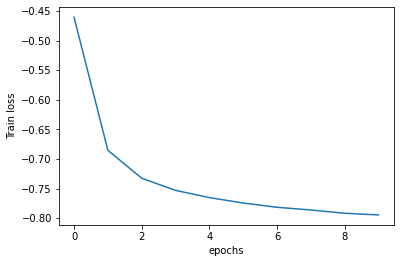

In [20]:
# Plot loss
plt.figure()
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel('epochs')
plt.ylabel('Train loss')
plt.savefig('../save/nn_{}_{}_{}.png'.format(args.dataset, args.model,
                                            args.epochs))